# Struttura dei test

Di seguito un'analisi comparativa sul modulo implementato (PPGA) in cui si va
a confrontare

- Versioni sequenziale e parallela di PPGA.
- PPGA e DEAP nelle loro versioni sequenziale e parallela.

I benchmark sono stati effettuati su una macchina con doppio processore AMD
EPYC 7313, ciascuno dei quali a 16 core con frequenza di clock massima a 3.7
GHz. Il problema di riferimento è quello di explainability in cui è stato
eseguito l'algoritmo genetico su un solo punto del dataset (32 feature) e su
una sola classe target. I parametri variabili presi in considerazione sono:

- **Modello predittivo**: RandomForestClassifier, SVC e MLPClassifier.
- **Numero di individui sintetici**: 1000, 2000, 4000, 8000, 16000.
- **Numero di worker**: 1, 2, 4, 8, 16, 32. Le esecuzioni con 1 worker
  corrispondono in realtà alla versione sequenziale dell'algoritmo.

Un'ulteriore precisazione riguarda l'utilizzo della _Hall of Fame_: in entrambi
i casi viene usata una hall of fame ma per PPGA questa ha una dimensione pari
al quella della popolazione iniziale, mentre per DEAP può contenere solo il
10% del numero di individui della popolazione iniziale.

Sono state esplorate tutte le possibili combinazioni di tali parametri e, per
ciascuna di esse sono stati eseguiti 10 test compiendo 5 iterazioni
dell'algoritmo. I risultati dei 10 test sono stati poi aggregati prendendo
media e deviazione standard dei tempi registrati.

Per entrambe le librerie sono stati misurati sia il tempo complessivo impiegato
dall'algoritmo, sia il solo tempo necessario alla fasi parallelizzate. Nel caso
di PPGA le fasi parallelizzate sono quelle di crossover, mutazione e
valutazione, mentre DEAP dà la possibilità di eseguire solo la fase di
valutazione in parallelo.

# PPGA

Per prima cosa sono state confrontate la versione sequenziale e quella parallela
di PPGA, rispetto a alla sua versione sequenziale. In questa fase sono stati
condotti dei test variando il numero di worker e, per ciascuno dei valori, è
stato gradualmente aumentato il numero di individui nella popolazione sintetica.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

ppga_df = pd.read_csv("../results/ppga32_bm.csv")
ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,MLPClassifier,1000,1,0.584240,0.014919,0.525779,0.014282
1,MLPClassifier,1000,2,0.464559,0.045308,0.327386,0.011896
2,MLPClassifier,1000,4,0.331937,0.022756,0.191897,0.014635
3,MLPClassifier,1000,8,0.397637,0.040630,0.186937,0.029460
4,MLPClassifier,1000,16,0.638822,0.024577,0.214145,0.020059
...,...,...,...,...,...,...,...
85,SVC,16000,2,6.972876,0.054969,5.787248,0.050291
86,SVC,16000,4,4.409749,0.128443,3.185300,0.095961
87,SVC,16000,8,3.321465,0.201285,1.929283,0.105347
88,SVC,16000,16,2.803912,0.169759,1.283837,0.065158


## Tempo d'esecuzione

Il dataframe contiene una colonna `time` e una colonna `ptime`. La prima indica
il tempo d'esecuzione totale, la seconda il tempo di esecuzione delle sole fasi
eseguite in parallelo.

Di seguito un grafico che riporta l'andamento del tempo d'esecuzione in
funzione del diverso numero di worker e su diverse dimensioni dell'input, per
ciascun modello.


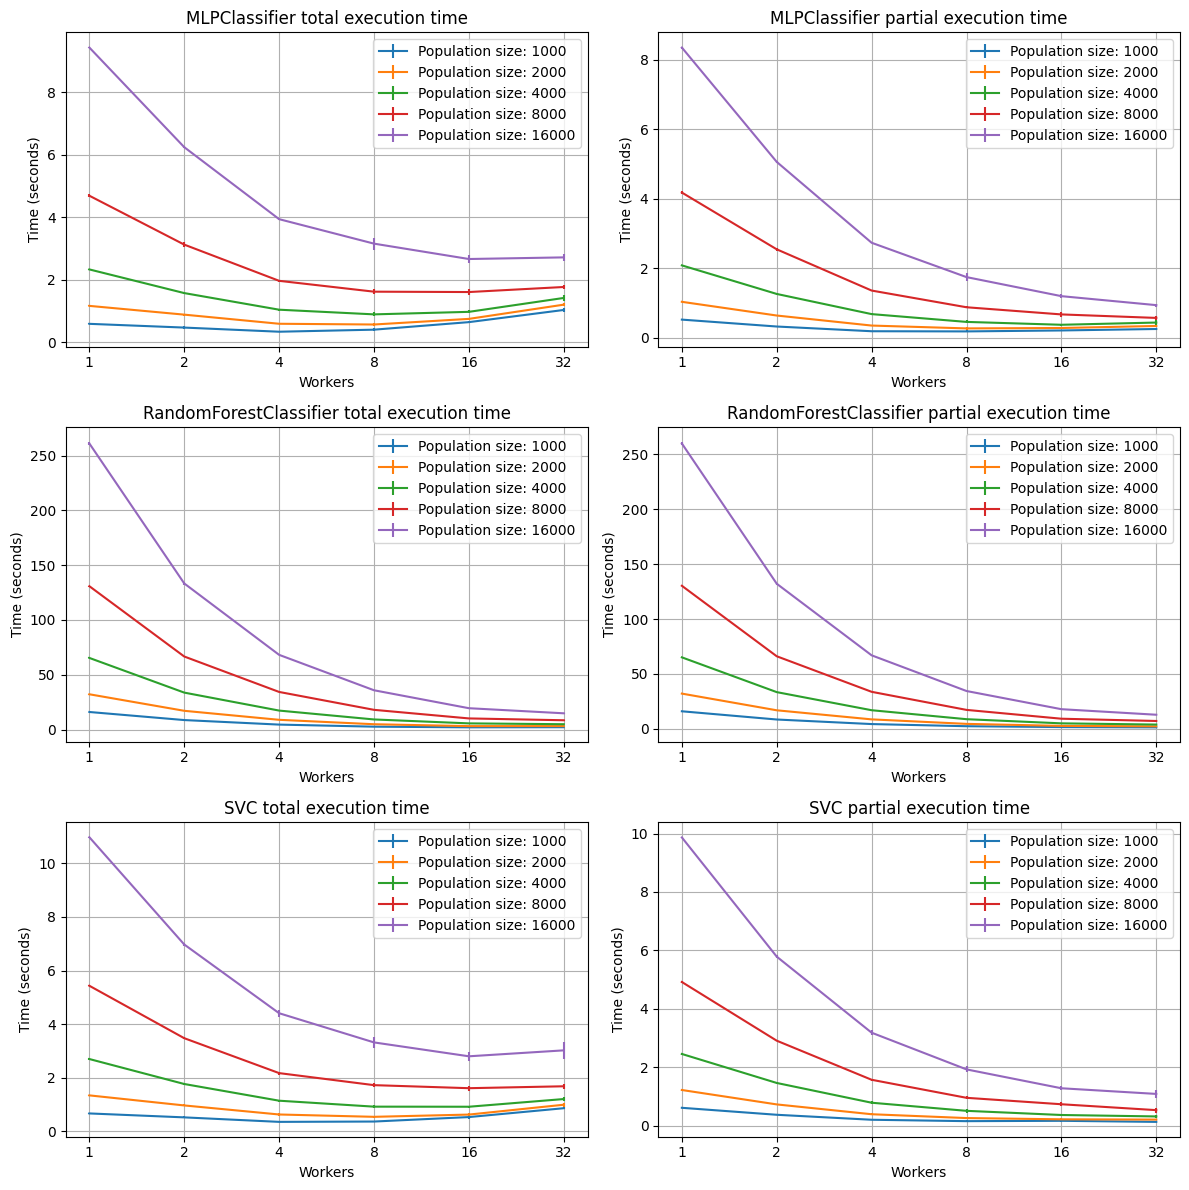

In [2]:
def plot_time(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][0].set_title(f"{model} total execution time")
            axes[i][0].set_xlabel("Workers")
            axes[i][0].set_ylabel("Time (seconds)")
            axes[i][0].errorbar(
                workers,
                df[mask]["time"].values,
                df[mask]["time_std"],
                label=f"Population size: {ps}",
            )

            axes[i][0].set_xscale("log", base=2)
            axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].grid()
            axes[i][0].legend()

            axes[i][1].set_title(f"{model} partial execution time")
            axes[i][1].set_xlabel("Workers")
            axes[i][1].set_ylabel("Time (seconds)")
            axes[i][1].errorbar(
                workers,
                df[mask]["ptime"].values,
                df[mask]["ptime_std"],
                label=f"Population size: {ps}",
            )

            axes[i][1].set_xscale("log", base=2)
            axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].grid()
            axes[i][1].legend()

    plt.tight_layout()
    plt.show()


plot_time(ppga_df)

## Speed up

Come seconda analisi è stato calcoato _speed up_ ottenuto per ogni
classificatore, impiegando un diverso numero di worker su popolazioni sintetiche
di dimensione via via maggiore. Anche qui viene calcolato sia lo speed up
ottenuto sull'esecuzione dell'intero algoritmo, sia quello ottenuto solo sulla
parte parallelizzata.

Vengono quindi aggiunte due colonne al dataframe: `speed_up` e `pure_speed_up`.
La prima è calcolata tramite il rapporto tra il tempo totale dell'algoritmo
sequenziale e il tempo totale di quello parallelo. La seconda viene calcolata
in modo del tutto analogo ma si considera solo il tempo delle fasi eseguite in
parallelo.


In [3]:
reference_times = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

ppga_df["speed_up"] = ppga_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

reference_ptimes = ppga_df[ppga_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["ptime"]

ppga_df["pure_speed_up"] = ppga_df.apply(
    lambda row: reference_ptimes.loc[(row["classifier"], row["population_size"])]
    / row["ptime"],
    axis=1,
)

ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up
0,MLPClassifier,1000,1,0.584240,0.014919,0.525779,0.014282,1.000000,1.000000
1,MLPClassifier,1000,2,0.464559,0.045308,0.327386,0.011896,1.257623,1.605994
2,MLPClassifier,1000,4,0.331937,0.022756,0.191897,0.014635,1.760096,2.739906
3,MLPClassifier,1000,8,0.397637,0.040630,0.186937,0.029460,1.469280,2.812602
4,MLPClassifier,1000,16,0.638822,0.024577,0.214145,0.020059,0.914558,2.455253
...,...,...,...,...,...,...,...,...,...
85,SVC,16000,2,6.972876,0.054969,5.787248,0.050291,1.573548,1.704861
86,SVC,16000,4,4.409749,0.128443,3.185300,0.095961,2.488159,3.097495
87,SVC,16000,8,3.321465,0.201285,1.929283,0.105347,3.303408,5.114051
88,SVC,16000,16,2.803912,0.169759,1.283837,0.065158,3.913159,7.685127


Di seguito vari grafici per vedere l'andamento dello speed up in relazione
al numero di individui sintetici generati. Sulla sinistra lo speed up ottenuto
sull'intero algoritmo, mentre sulla destra lo speed up ottenuto sulla sola
parte parallelizzata.

Nella colonna a destra, viene tracciata anche la linea (tratteggiata verde) che
definisce lo speed up ideale. Dato che si considera solo la parte parallelizzata
viene, lo speed up "ideale" è lineare. Ci aspettiamo quindi un valore di speed
up di $n$ se impieghiamo $n$ worker per il lavoro.

Come è facile notare, il Random Forest, che è anche il più lento, è quello che
trae più beneficio da una parallelizzazione più pesante. Gli altri modelli
sono molto più performanti in fase di predizione ed è quindi più difficile
ottenere un valore di speed up vicino al numero di worker utilizzati,
soprattutto quando se ne usano tanti.


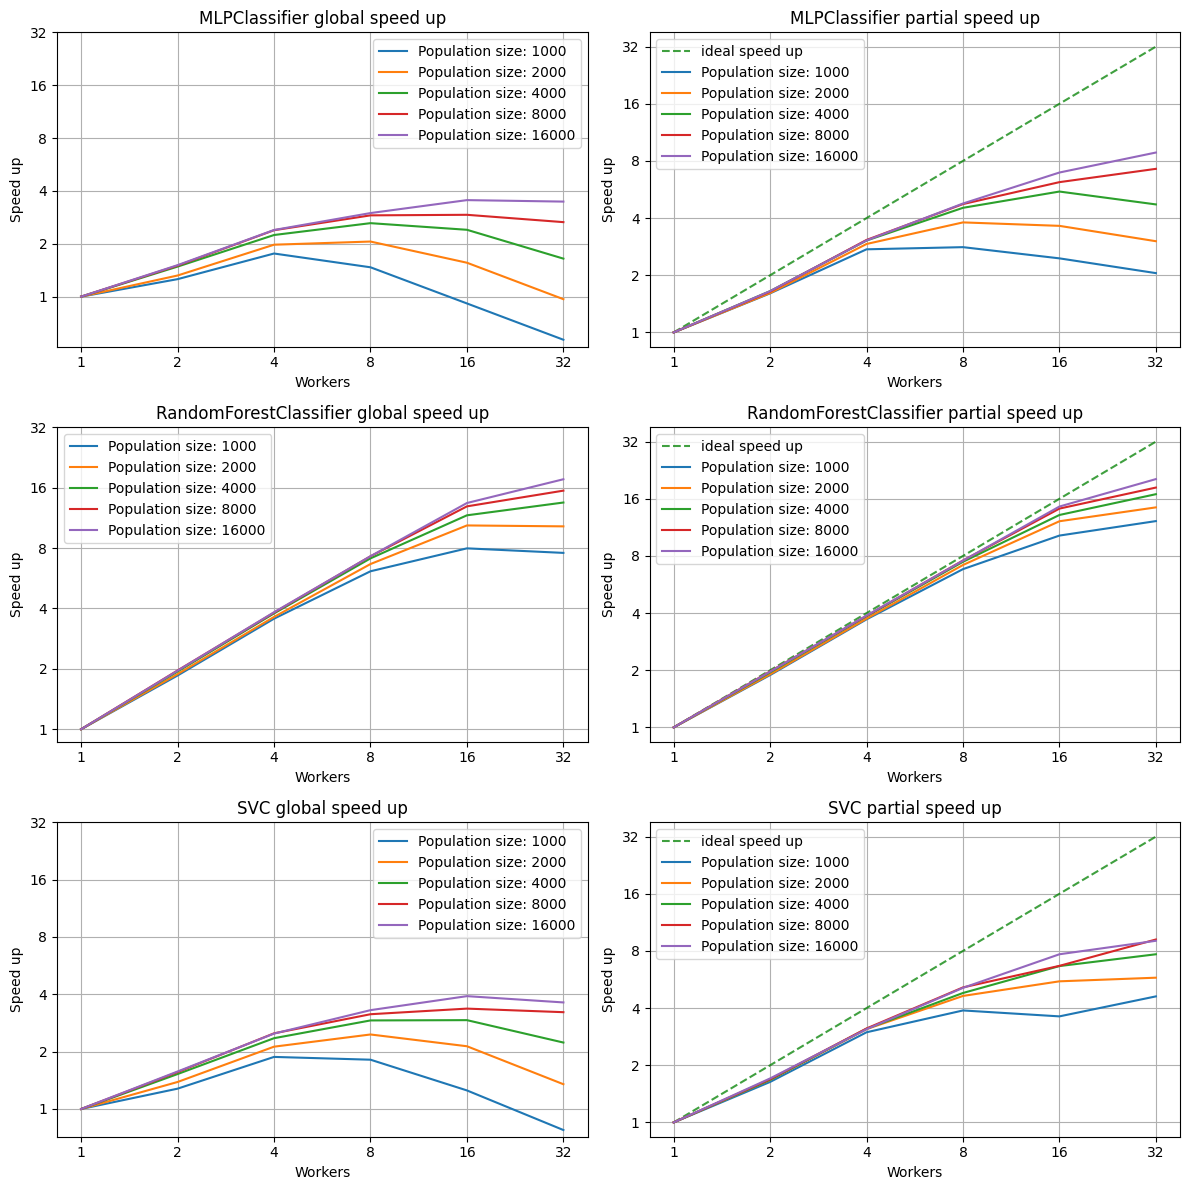

In [4]:
def plot_speed_up(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    for i, model in enumerate(models):
        axes[i][1].plot(workers, workers, "g--", alpha=0.75, label="ideal speed up")
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][0].set_title(f"{model} global speed up")
            axes[i][0].set_xlabel("Workers")
            axes[i][0].set_ylabel("Speed up")
            axes[i][0].errorbar(
                workers,
                df[mask]["speed_up"].values,
                label=f"Population size: {ps}",
            )

            axes[i][0].set_xscale("log", base=2)
            axes[i][0].set_yscale("log", base=2)
            axes[i][0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][0].grid()
            axes[i][0].legend()

            axes[i][1].set_title(f"{model} partial speed up")
            axes[i][1].set_xlabel("Workers")
            axes[i][1].set_ylabel("Speed up")
            axes[i][1].errorbar(
                workers,
                df[mask]["pure_speed_up"].values,
                label=f"Population size: {ps}",
            )

            axes[i][1].set_xscale("log", base=2)
            axes[i][1].set_yscale("log", base=2)
            axes[i][1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].set_yticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i][1].grid()
            axes[i][1].legend()

    plt.tight_layout()
    plt.show()


plot_speed_up(ppga_df)

## Stabilità

Come ultima analisi è stata valutata la stabilità delle performance
dell'algoritmo stesso andando a calcolare il coefficiente di variazione del
tempo impiegato. Tale coefficiente è stato ottenuto tramite il rapporto tra la
deviazione standard e la media del tempo impiegato.


In [5]:
ppga_df["var_coeff"] = ppga_df["time_std"] / ppga_df["time"]
ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up,var_coeff
0,MLPClassifier,1000,1,0.584240,0.014919,0.525779,0.014282,1.000000,1.000000,0.025536
1,MLPClassifier,1000,2,0.464559,0.045308,0.327386,0.011896,1.257623,1.605994,0.097528
2,MLPClassifier,1000,4,0.331937,0.022756,0.191897,0.014635,1.760096,2.739906,0.068555
3,MLPClassifier,1000,8,0.397637,0.040630,0.186937,0.029460,1.469280,2.812602,0.102180
4,MLPClassifier,1000,16,0.638822,0.024577,0.214145,0.020059,0.914558,2.455253,0.038472
...,...,...,...,...,...,...,...,...,...,...
85,SVC,16000,2,6.972876,0.054969,5.787248,0.050291,1.573548,1.704861,0.007883
86,SVC,16000,4,4.409749,0.128443,3.185300,0.095961,2.488159,3.097495,0.029127
87,SVC,16000,8,3.321465,0.201285,1.929283,0.105347,3.303408,5.114051,0.060601
88,SVC,16000,16,2.803912,0.169759,1.283837,0.065158,3.913159,7.685127,0.060544


In questo modo è possibile vedere la stabilità dell'algoritmo al variare di
parametri come numero di worker e dimensione della popolazione.

Come soglia per separare i test più _stabili_ dagli altri è stata impostata una
soglia del 10% per il coefficiente di variabilità.


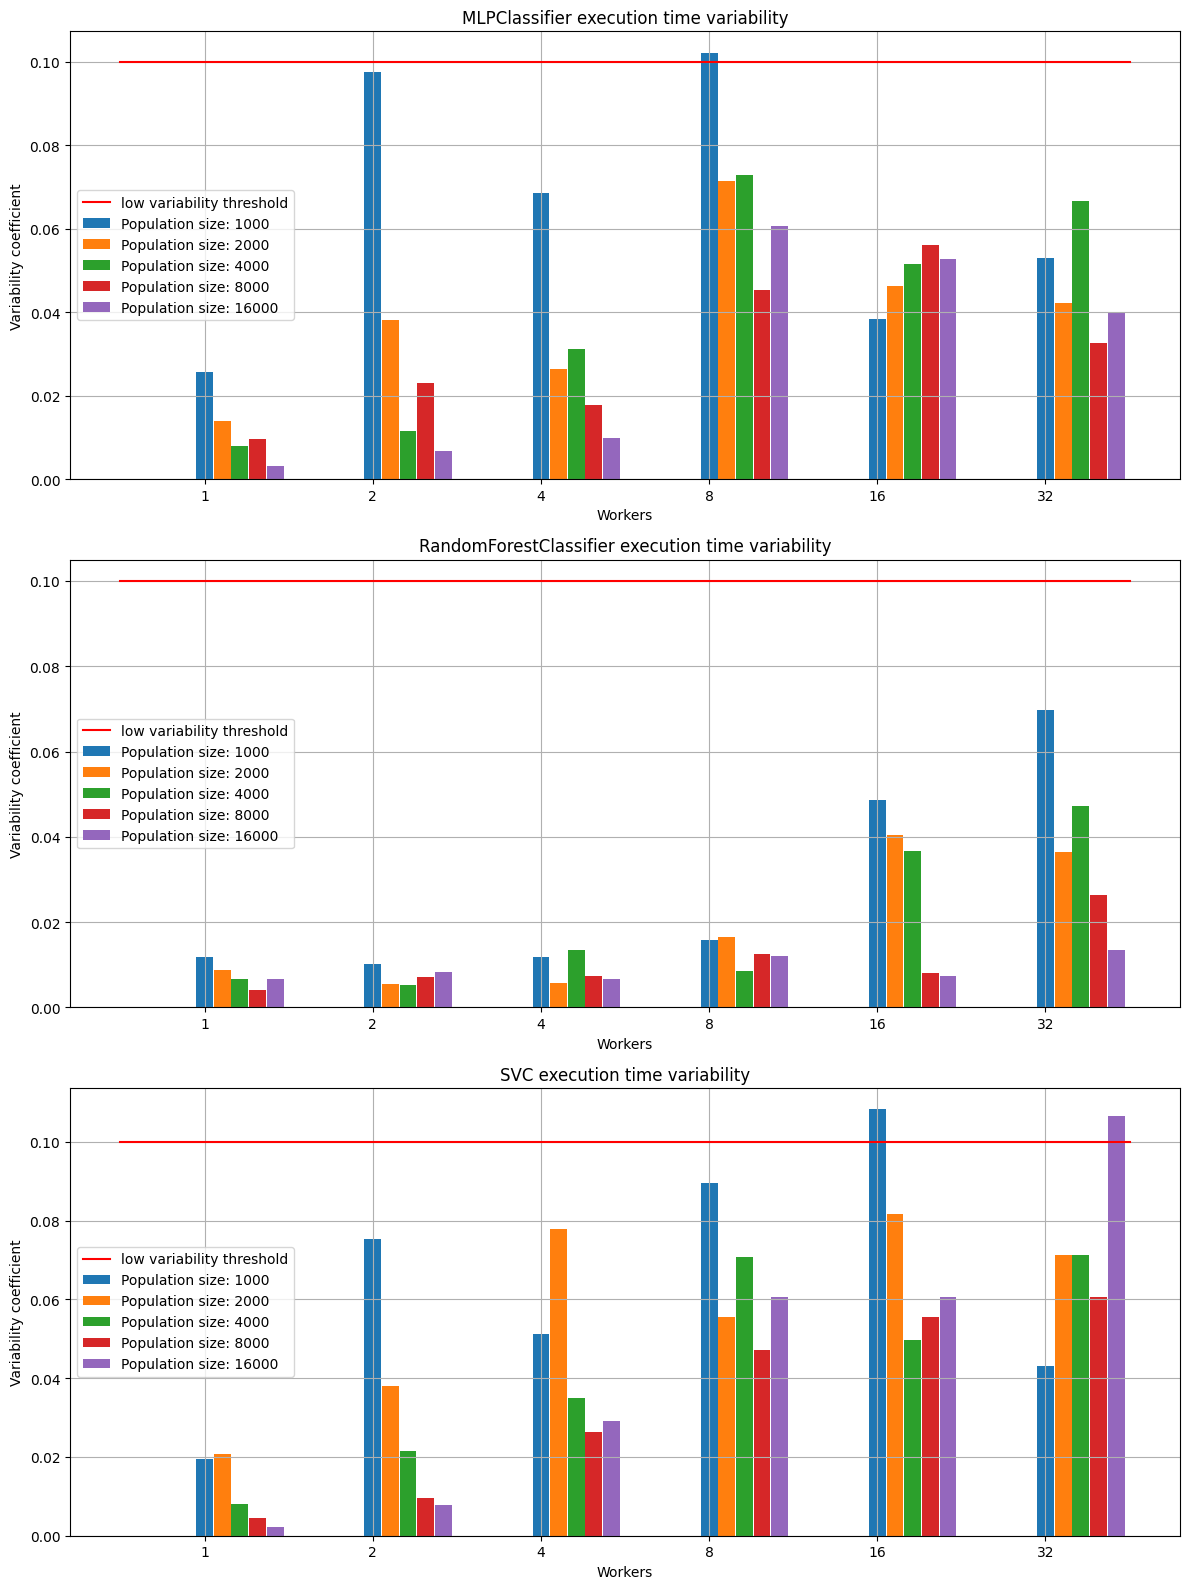

In [6]:
def plot_var_coeff(df: pd.DataFrame):
    models = df["classifier"].unique()
    workers = np.log2(np.array(df["workers"].unique()))
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(3, 1, figsize=(12, 16))

    for model, ax in zip(models, axes):
        ax.plot([-0.5, 5.5], [0.1, 0.1], c="r", label="low variability threshold")
        for i, ps in enumerate(population_sizes):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            ax.set_title(f"{model} execution time variability")
            ax.set_xlabel("Workers")
            ax.set_ylabel("Variability coefficient")
            ax.bar(
                workers + i * 0.105,
                df[mask]["var_coeff"].values,
                width=0.1,
                label=f"Population size: {ps}",
            )

            ax.set_xticks(workers, labels=[int(2**w) for w in workers])
            ax.grid()
            ax.legend()

    plt.tight_layout()
    plt.show()


plot_var_coeff(ppga_df)

# DEAP

Il modulo DEAP offre due metodi per sfruttare il parallelismo. Il primo tramite
il modulo `multiprocessing` e il secondo tramite `scoop`. Di seguito un'analisi
della versione con `multiprocessing`. Le analisi sono perfettamente analoghe
alle precedenti.


In [7]:
deap_df = pd.read_csv("../results/deap32_hof.csv")
deap_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,MLPClassifier,1000,1,0.894399,0.017528,0.617536,0.004897
1,MLPClassifier,1000,2,0.764245,0.025862,0.470619,0.030199
2,MLPClassifier,1000,4,0.665386,0.037758,0.386755,0.033711
3,MLPClassifier,1000,8,0.775329,0.045068,0.478835,0.025011
4,MLPClassifier,1000,16,0.886869,0.045487,0.584285,0.034067
...,...,...,...,...,...,...,...
85,SVC,16000,2,60.647000,0.699872,8.497075,0.365557
86,SVC,16000,4,57.190492,0.313832,5.544533,0.109754
87,SVC,16000,8,56.944647,0.663168,4.956315,0.050668
88,SVC,16000,16,56.774415,0.398111,4.762668,0.104942


## Tempo d'esecuzione

Di seguito sono riportati i grafici dell'andamento del tempo d'esecuzione al
variare del numero di worker.


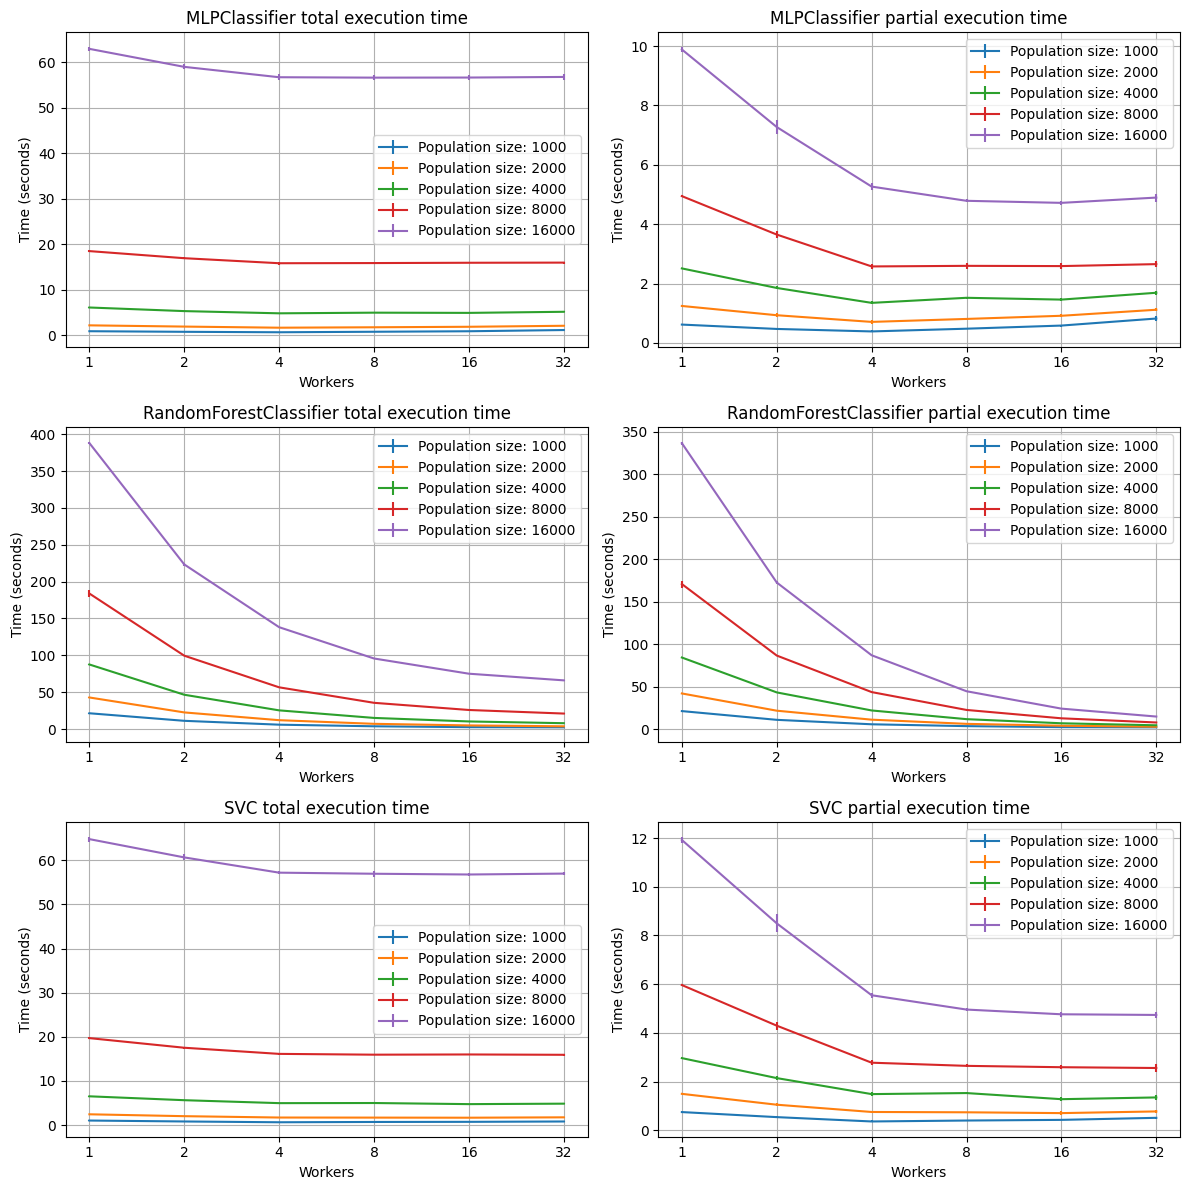

In [8]:
plot_time(deap_df)

## Speed up

Come prima è stato calcolato e analizzato lo speed up ottenuto (sia globale
che parziale).


In [9]:
reference_times = deap_df[deap_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["time"]

deap_df["speed_up"] = deap_df.apply(
    lambda row: reference_times.loc[(row["classifier"], row["population_size"])]
    / row["time"],
    axis=1,
)

reference_ptimes = deap_df[deap_df["workers"] == 1].set_index(
    ["classifier", "population_size"]
)["ptime"]

deap_df["pure_speed_up"] = deap_df.apply(
    lambda row: reference_ptimes.loc[(row["classifier"], row["population_size"])]
    / row["ptime"],
    axis=1,
)

deap_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up
0,MLPClassifier,1000,1,0.894399,0.017528,0.617536,0.004897,1.000000,1.000000
1,MLPClassifier,1000,2,0.764245,0.025862,0.470619,0.030199,1.170303,1.312177
2,MLPClassifier,1000,4,0.665386,0.037758,0.386755,0.033711,1.344181,1.596709
3,MLPClassifier,1000,8,0.775329,0.045068,0.478835,0.025011,1.153573,1.289663
4,MLPClassifier,1000,16,0.886869,0.045487,0.584285,0.034067,1.008491,1.056908
...,...,...,...,...,...,...,...,...,...
85,SVC,16000,2,60.647000,0.699872,8.497075,0.365557,1.068301,1.403027
86,SVC,16000,4,57.190492,0.313832,5.544533,0.109754,1.132868,2.150159
87,SVC,16000,8,56.944647,0.663168,4.956315,0.050668,1.137758,2.405341
88,SVC,16000,16,56.774415,0.398111,4.762668,0.104942,1.141170,2.503140


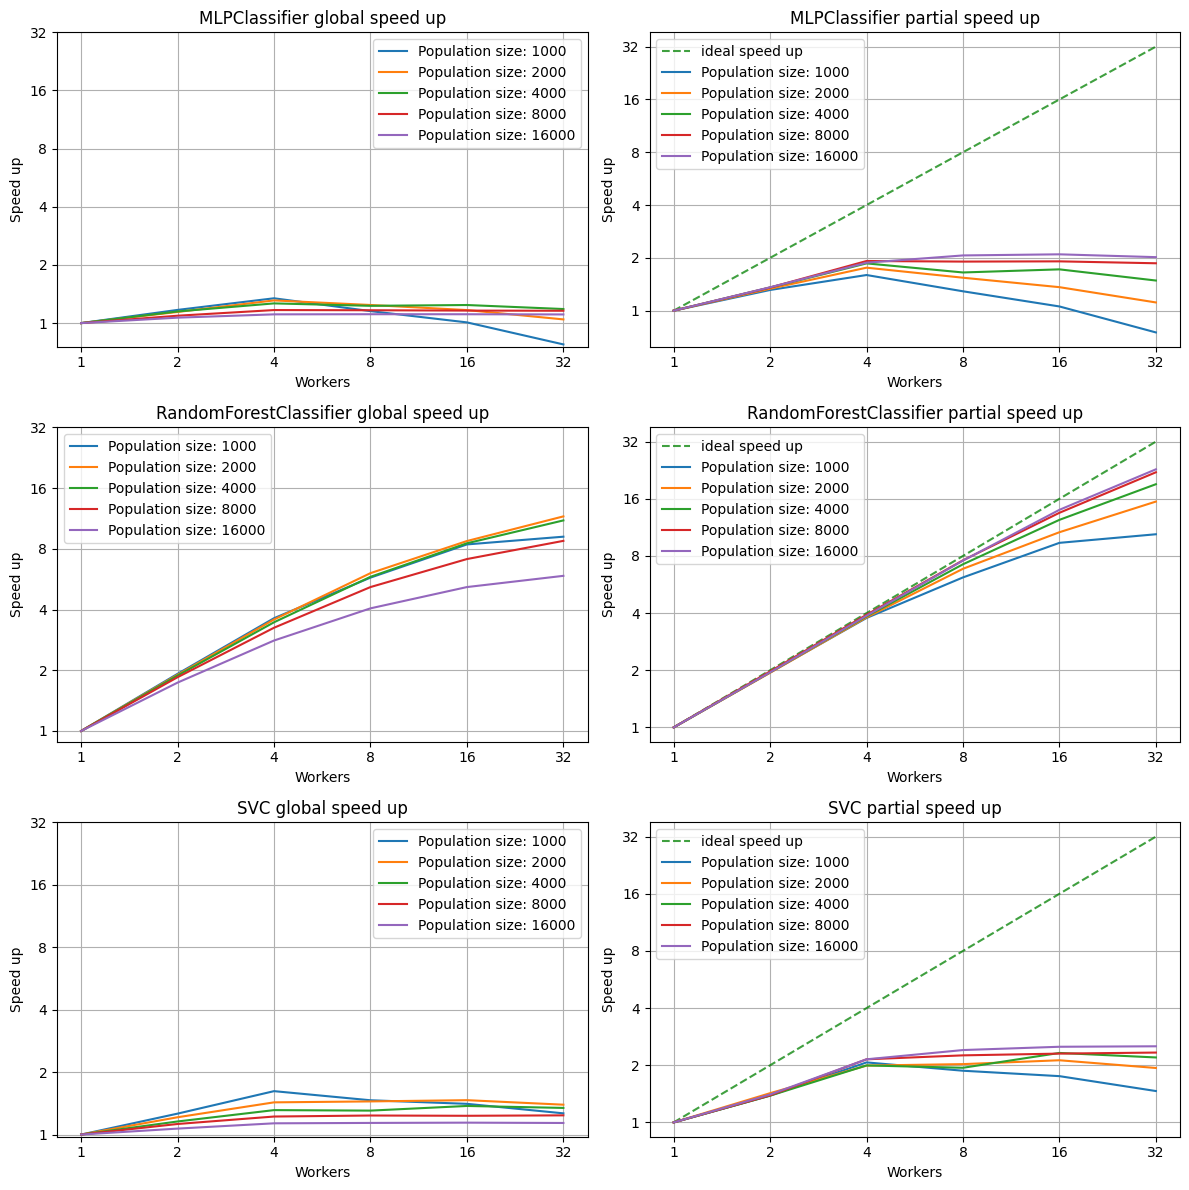

In [10]:
plot_speed_up(deap_df)

## Stabilità

Analoghe considerazioni per la valutazione della stabilità dell'algoritmo.


In [11]:
deap_df["var_coeff"] = deap_df["time_std"] / deap_df["time"]
deap_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,pure_speed_up,var_coeff
0,MLPClassifier,1000,1,0.894399,0.017528,0.617536,0.004897,1.000000,1.000000,0.019598
1,MLPClassifier,1000,2,0.764245,0.025862,0.470619,0.030199,1.170303,1.312177,0.033840
2,MLPClassifier,1000,4,0.665386,0.037758,0.386755,0.033711,1.344181,1.596709,0.056747
3,MLPClassifier,1000,8,0.775329,0.045068,0.478835,0.025011,1.153573,1.289663,0.058128
4,MLPClassifier,1000,16,0.886869,0.045487,0.584285,0.034067,1.008491,1.056908,0.051289
...,...,...,...,...,...,...,...,...,...,...
85,SVC,16000,2,60.647000,0.699872,8.497075,0.365557,1.068301,1.403027,0.011540
86,SVC,16000,4,57.190492,0.313832,5.544533,0.109754,1.132868,2.150159,0.005487
87,SVC,16000,8,56.944647,0.663168,4.956315,0.050668,1.137758,2.405341,0.011646
88,SVC,16000,16,56.774415,0.398111,4.762668,0.104942,1.141170,2.503140,0.007012


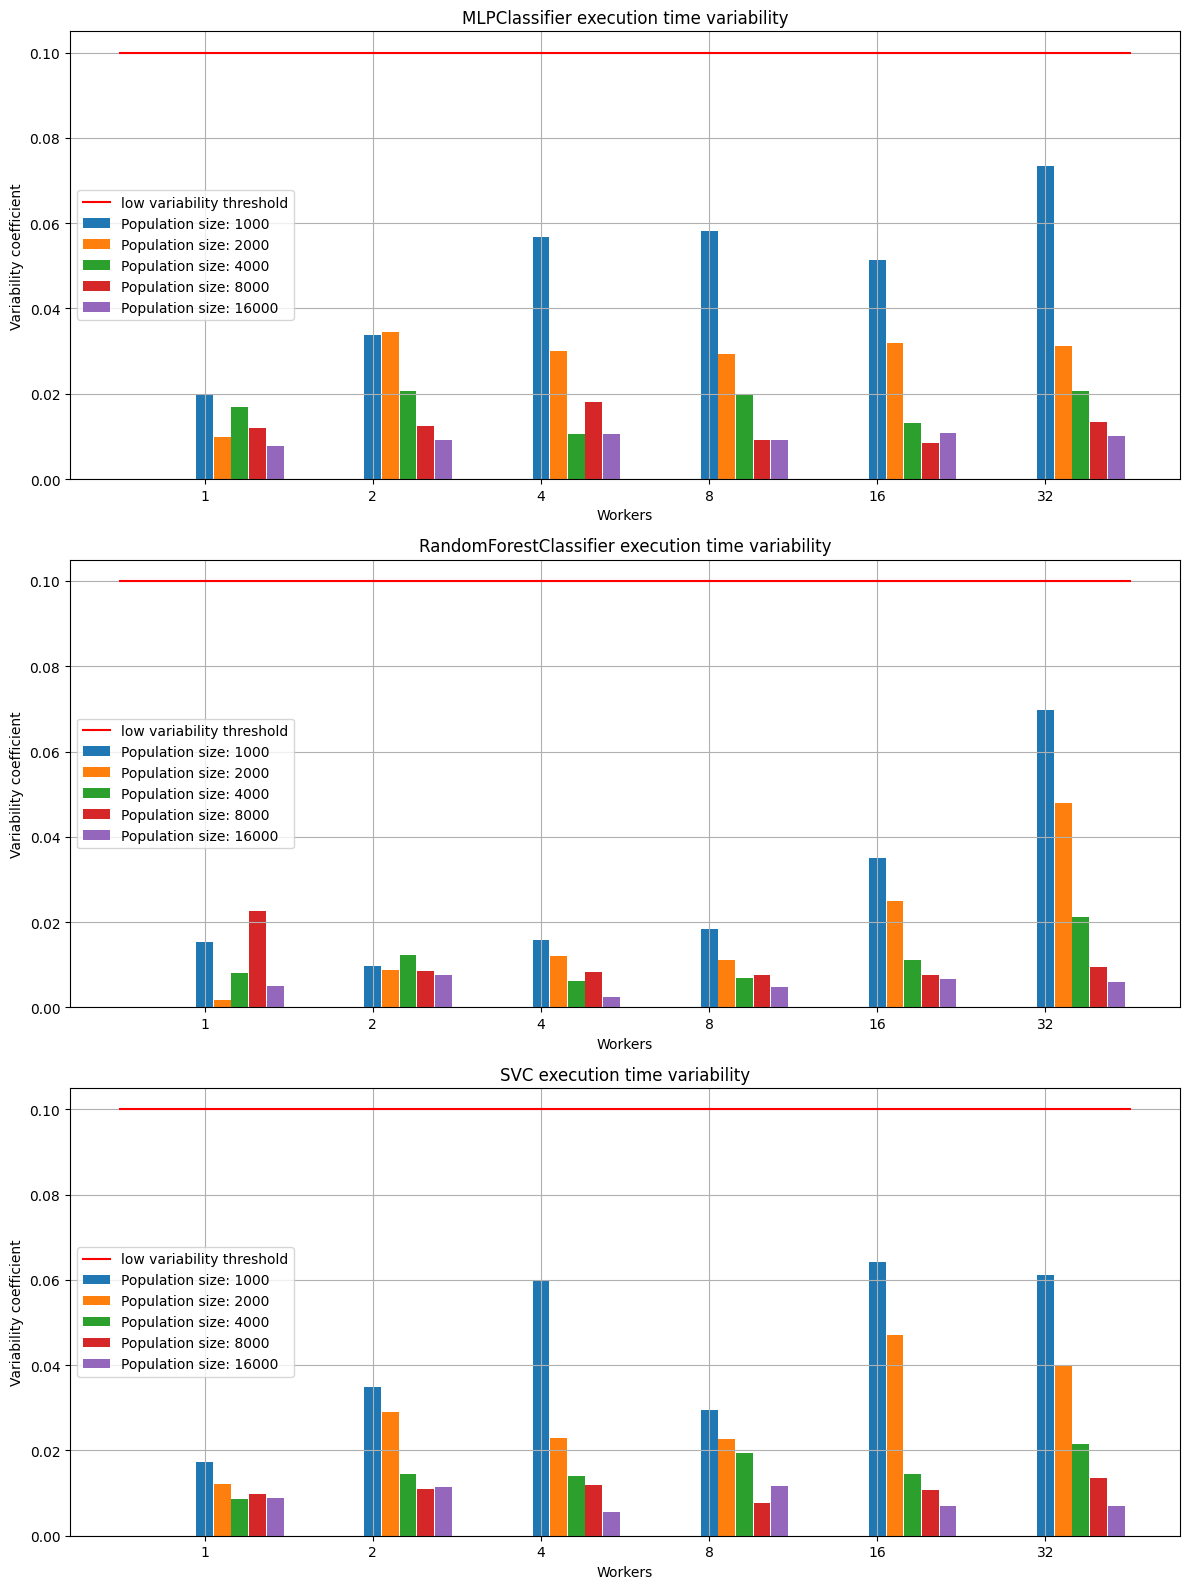

In [12]:
plot_var_coeff(deap_df)

# Confronto

Il confronto tra le due librerie è avvenuto comparando tra loro tre parametri
chiave:

- Tempo d'esecuzione
- Speed up
- Coefficiente di speed up

L'ultimo è un parametro che ci permette di paragonare lo speed up in modo
proporzionale tra i due algoritmi che possono aver ottenuto tempi d'esecuzione
differenti.

## Tempo d'esecuzione

Il primo confronto è stato fatto sul tempo d'esecuzione totale dei due
algoritmi.


In [13]:
time_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["time"].values,
        "deap": deap_df["time"].values,
    }
)

time_cmp

,classifier,population_size,workers,ppga,deap
0,MLPClassifier,1000,1,0.584240,0.894399
1,MLPClassifier,1000,2,0.464559,0.764245
2,MLPClassifier,1000,4,0.331937,0.665386
3,MLPClassifier,1000,8,0.397637,0.775329
4,MLPClassifier,1000,16,0.638822,0.886869
...,...,...,...,...,...
85,SVC,16000,2,6.972876,60.647000
86,SVC,16000,4,4.409749,57.190492
87,SVC,16000,8,3.321465,56.944647
88,SVC,16000,16,2.803912,56.774415


Come possiamo vedere dai grafici di seguito sembra che DEAP sia leggermente
più lento nella quasi totalità dei casi.


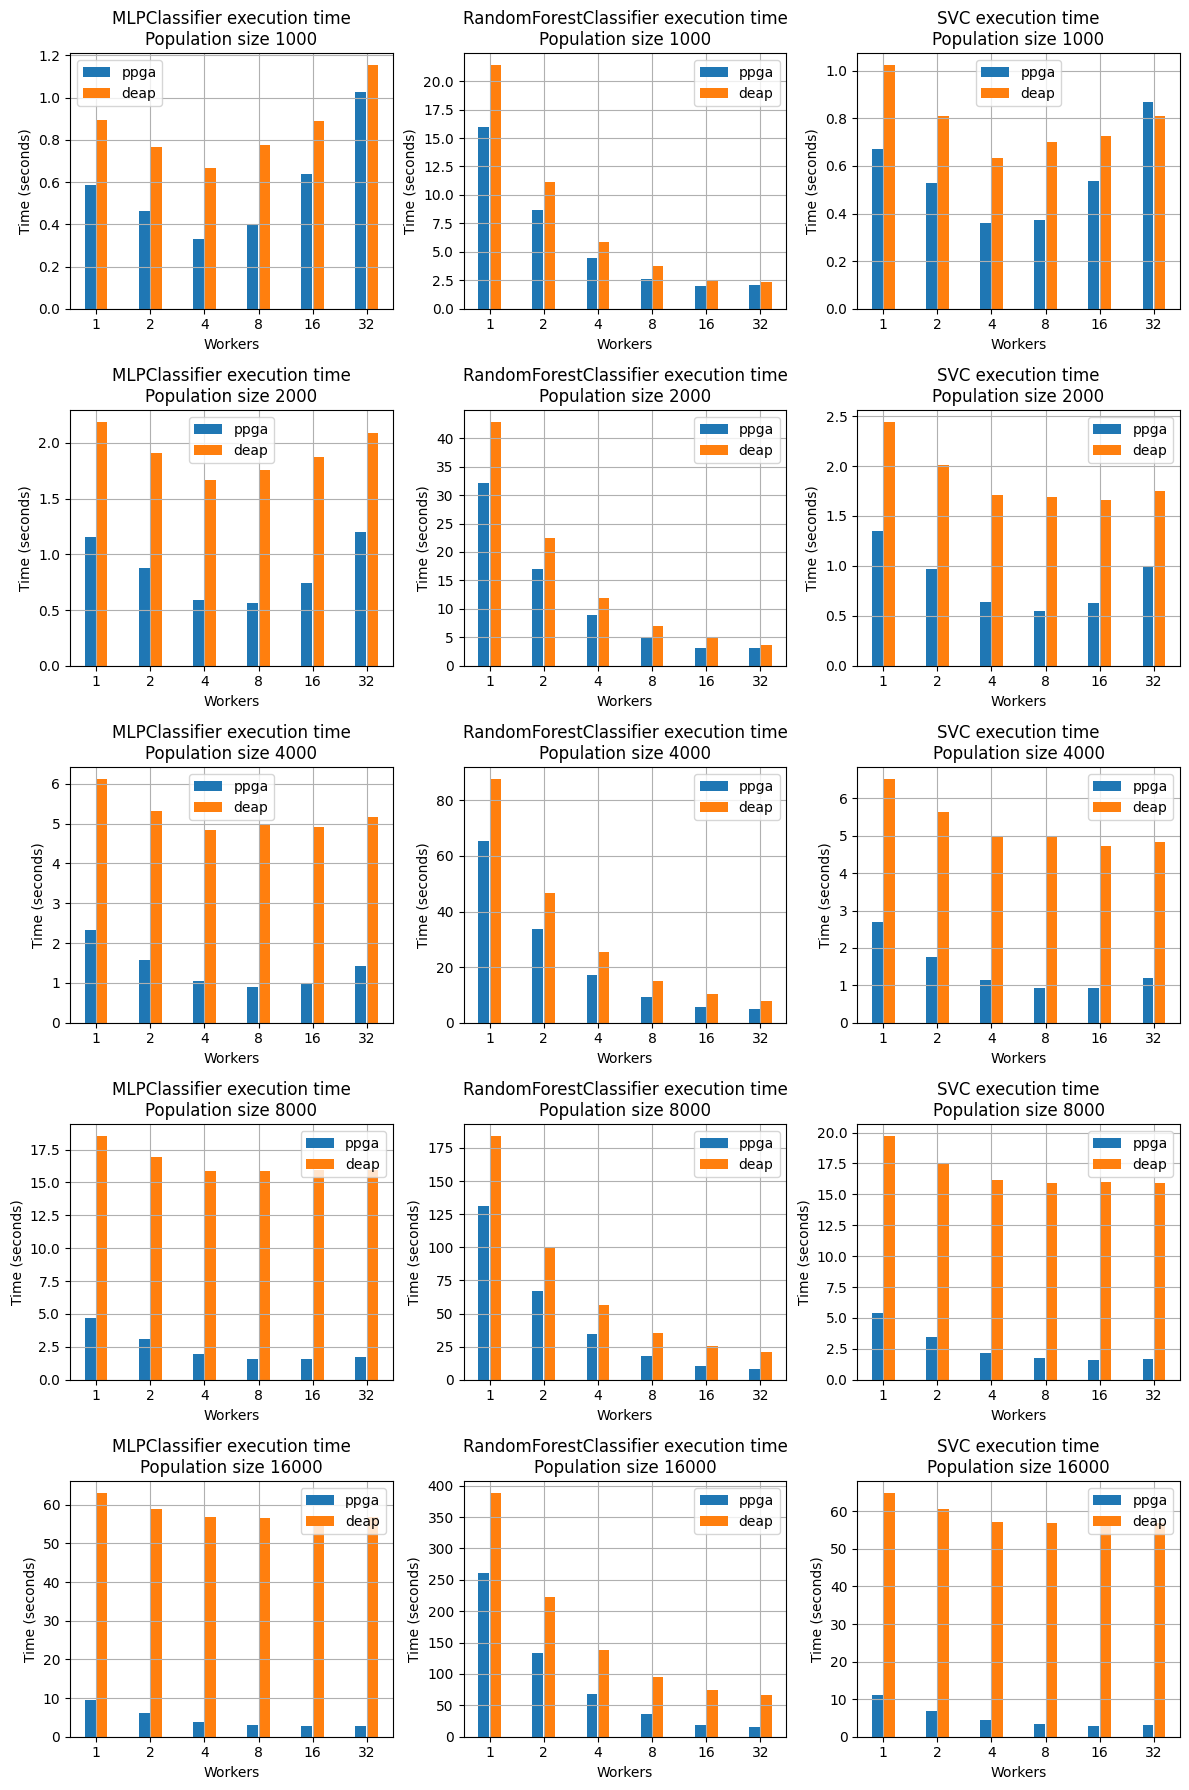

In [14]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} execution time\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Time (seconds)")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(time_cmp)

Di seguito un confronto tra il numero di volte in cui PPGA ha offerto
performance migliori rispetto a DEAP.


In [15]:
ppga_better_time = time_cmp[time_cmp["ppga"] < time_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_time) / len(time_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 98.89% of the times


Andiamo a vedere i valori minimi, medi e massimi dell'aumento di performance.


In [16]:
improvement = (
    (ppga_better_time["deap"] - ppga_better_time["ppga"])
    / ppga_better_time["deap"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

min improvement: 9.23%
mean improvement: 58.21%
max improvement: 95.31%


La stessa analisi è stata ripetuta ma considerando solo i casi in cui DEAP ha
fornito le performance migliori.


In [17]:
deap_better_time = time_cmp[time_cmp["deap"] < time_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_time) / len(time_cmp) * 100.0:.2f}% of the times"
)

improvement = (
    (deap_better_time["ppga"] - deap_better_time["deap"])
    / deap_better_time["ppga"]
    * 100.0
)
print(f"min improvement: {improvement.min():.2f}%")
print(f"mean improvement: {improvement.mean():.2f}%")
print(f"max improvement: {improvement.max():.2f}%")

deap better than ppga 1.11% of the times
min improvement: 6.86%
mean improvement: 6.86%
max improvement: 6.86%


## Speed up

Il secondo parametro di confronto è lo speed up. Dato che si vogliono mettere a
confronto le capacità di sfruttare al meglio l'architettura multicore della CPU,
in questo caso si sono considerati i soli valori di speed up nella fase
parallelizzata.


In [18]:
speedup_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": ppga_df["pure_speed_up"].values,
        "deap": deap_df["pure_speed_up"].values,
    }
)

speedup_cmp = speedup_cmp[speedup_cmp["workers"] != 1]
speedup_cmp

,classifier,population_size,workers,ppga,deap
1,MLPClassifier,1000,2,1.605994,1.312177
2,MLPClassifier,1000,4,2.739906,1.596709
3,MLPClassifier,1000,8,2.812602,1.289663
4,MLPClassifier,1000,16,2.455253,1.056908
5,MLPClassifier,1000,32,2.052678,0.751599
...,...,...,...,...,...
85,SVC,16000,2,1.704861,1.403027
86,SVC,16000,4,3.097495,2.150159
87,SVC,16000,8,5.114051,2.405341
88,SVC,16000,16,7.685127,2.503140


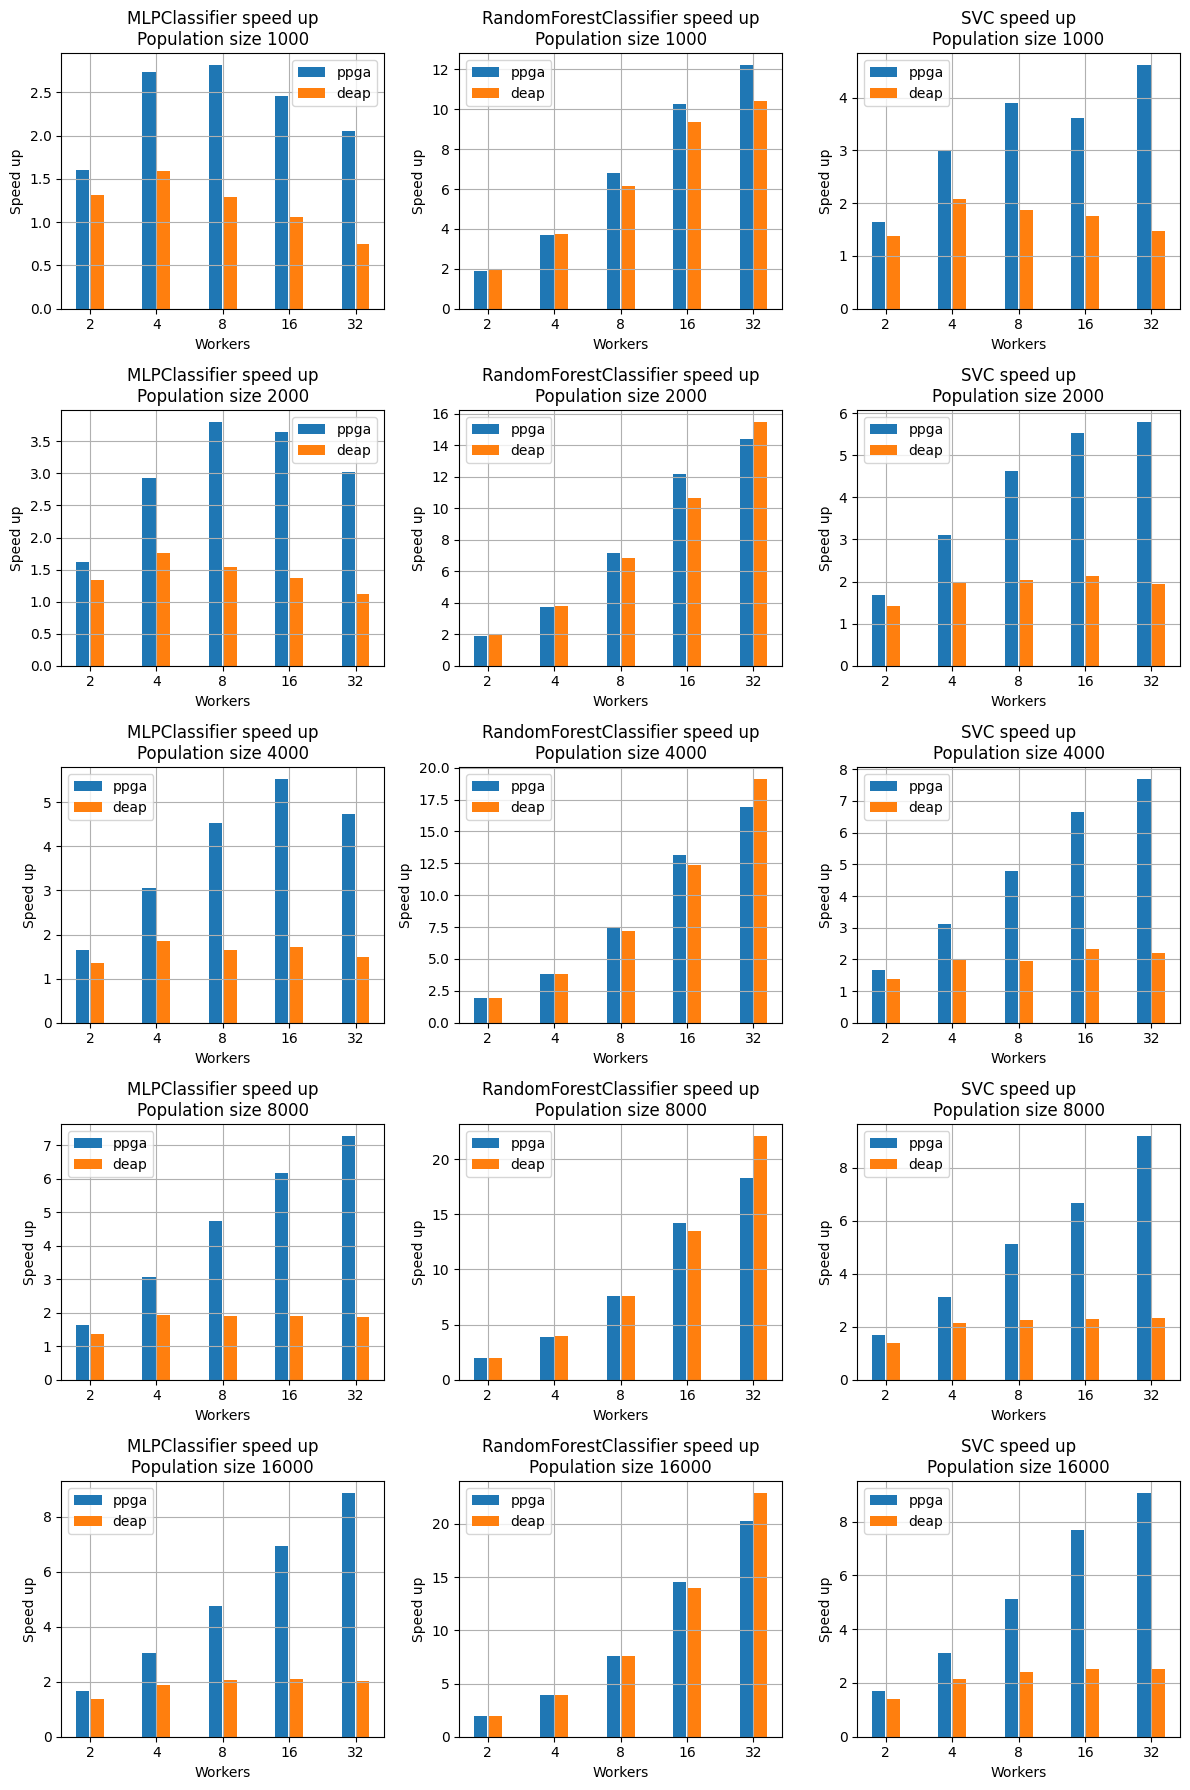

In [19]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(speedup_cmp)

Anche in questo caso PPGA sembra fornire valori di speed up migliori e più
stabili via via crescenti all'aumentare del numero di worker. DEAP sembra
invece non riuscire a sfruttare a pieno l'architettura multicore su carichi
di lavoro più bassi.


In [20]:
ppga_better_speedup = speedup_cmp[speedup_cmp["ppga"] > speedup_cmp["deap"]]
print(
    f"ppga better than deap {len(ppga_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

deap_better_speedup = speedup_cmp[speedup_cmp["deap"] > speedup_cmp["ppga"]]
print(
    f"deap better than ppga {len(deap_better_speedup) / len(speedup_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 82.67% of the times
deap better than ppga 17.33% of the times


## Coefficiente di speed up

Confrontare il tempo d'esecuzione può essere un buon indice per paragonare le
performance dei due algoritmi, quando però andiamo a paragonare i valori di
speed up non otteniamo una vera e propria misura di quanto un modello di calcolo
parallelo sia migliore rispetto ad un altro. Questo è anche dovuto al fatto
che il tempo d'esecuzione, a parità di worker impiegati, potrebbe variare.
Diventa quindi necessario ricavare una misura che sia proporzionale al tempo
d'esecuzione. Di seguito viene calcolato un "coefficiente di speed up"

$$c = \frac{s}{t}$$

dove $s$ è lo speed up ottenuto e $t$ il tempo impiegato dai due algoritmi
nella solo fase parallelizzata. Questo indice dovrebbe favorire l'algoritmo
più veloce e che allo stesso tempo offre valori di speed up più elevati.


In [21]:
speedup_coeff_cmp = pd.DataFrame(
    {
        "classifier": ppga_df["classifier"].values,
        "population_size": ppga_df["population_size"].values,
        "workers": ppga_df["workers"].values,
        "ppga": (ppga_df["pure_speed_up"] / ppga_df["ptime"]).values,
        "deap": (deap_df["pure_speed_up"] / deap_df["ptime"]).values,
    }
)

speedup_coeff_cmp = speedup_coeff_cmp[speedup_coeff_cmp["workers"] != 1]
speedup_coeff_cmp

,classifier,population_size,workers,ppga,deap
1,MLPClassifier,1000,2,4.905509,2.788194
2,MLPClassifier,1000,4,14.278015,4.128475
3,MLPClassifier,1000,8,15.045717,2.693336
4,MLPClassifier,1000,16,11.465397,1.808891
5,MLPClassifier,1000,32,8.013795,0.914768
...,...,...,...,...,...
85,SVC,16000,2,0.294589,0.165119
86,SVC,16000,4,0.972434,0.387798
87,SVC,16000,8,2.650752,0.485308
88,SVC,16000,16,5.986061,0.525575


Dalla tabella e dai grafici riportati di seguito si può notare come PPGA
offra, nella maggior parte dei casi, un coefficiente migliore. Dobbiamo però
considerare anche l'andamento di tale coefficiente caso per caso. Se rimane
stabile o tende a crescere con il crescere del numero di worker, potrebbe
essere un buon indice per valutare la scalabilità dell'algoritmo su un numero
ancora più alto di worker.


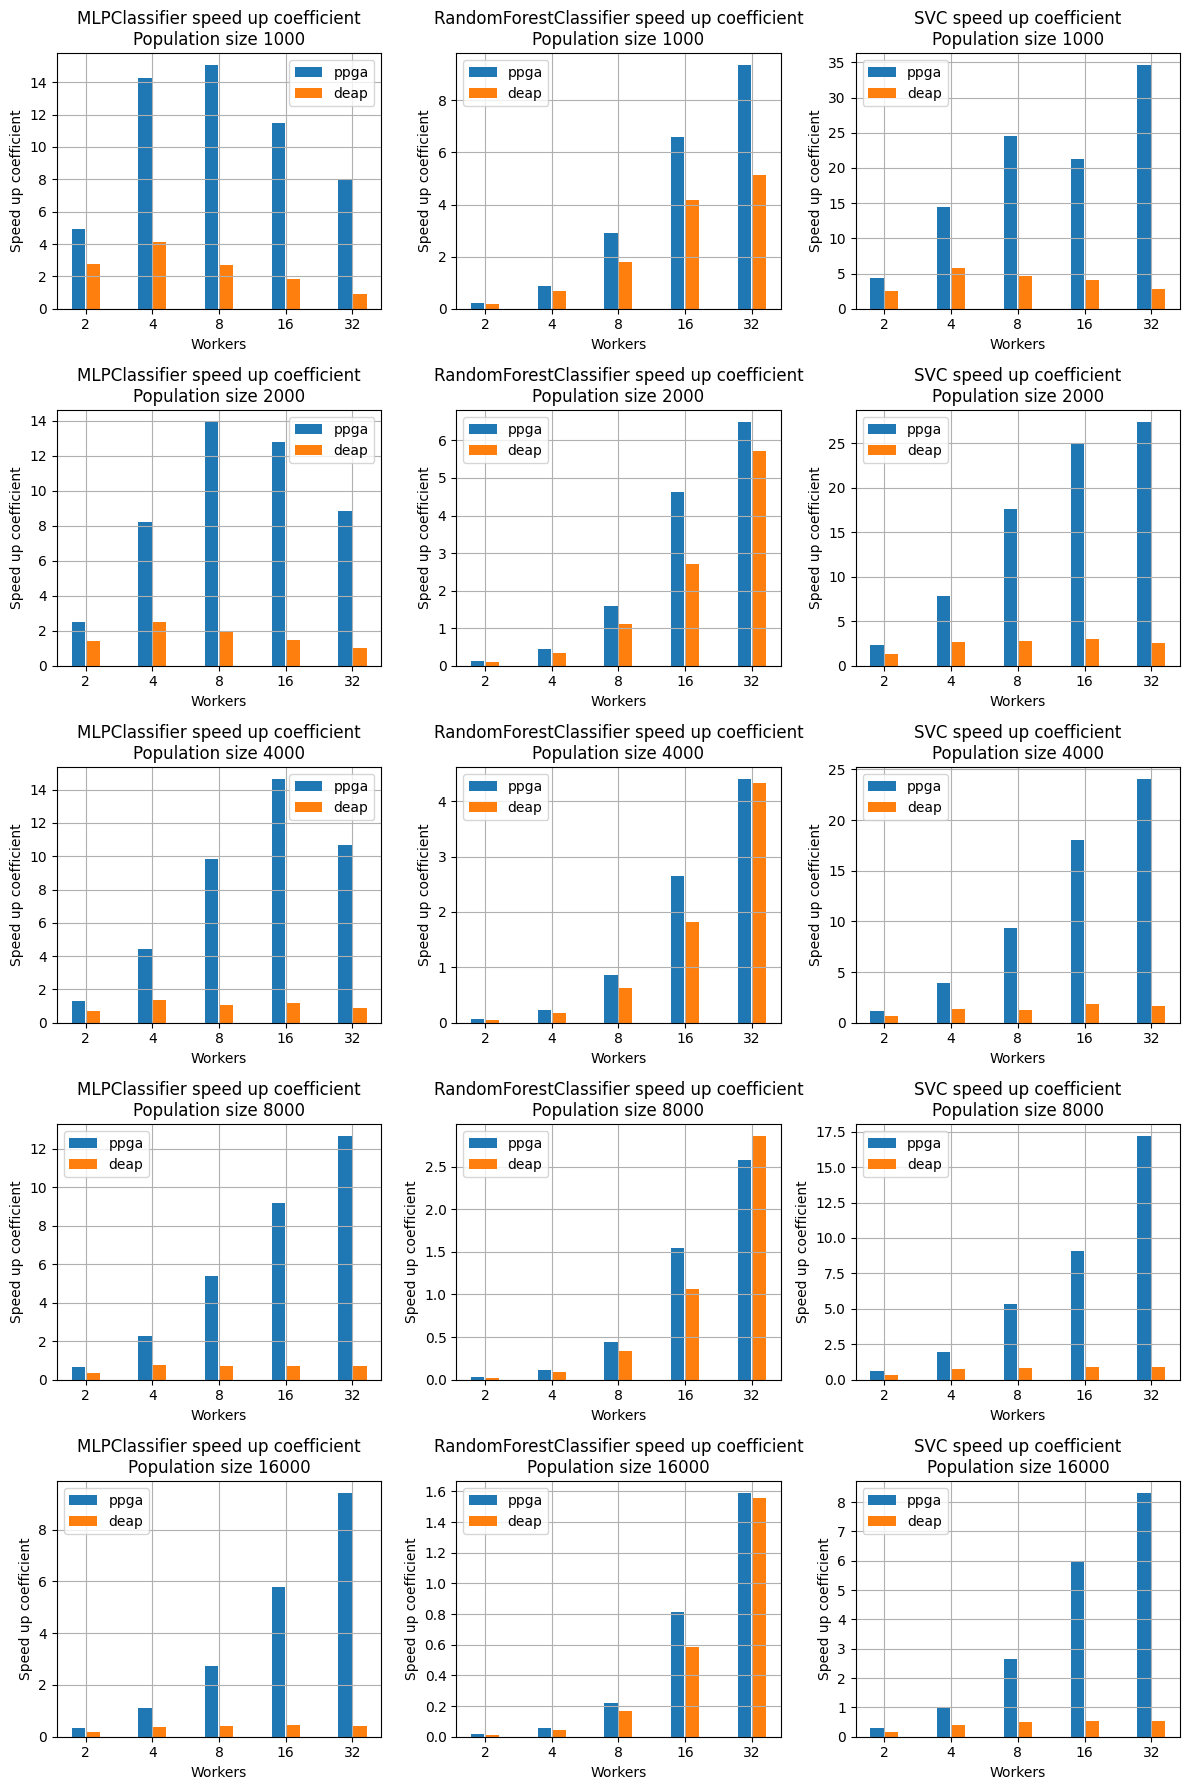

In [22]:
def plot_time_diff(df):
    models = df["classifier"].unique()
    workers = np.log2(df["workers"].unique())
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(population_sizes), len(models), figsize=(12, 18))

    for i, ps in enumerate(population_sizes):
        for j, model in enumerate(models):
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i][j].set_title(f"{model} speed up coefficient\nPopulation size {ps}")
            axes[i][j].set_xlabel("Workers")
            axes[i][j].set_ylabel("Speed up coefficient")
            axes[i][j].bar(
                workers - 0.11, df[mask]["ppga"].values, width=0.2, label="ppga"
            )
            axes[i][j].bar(
                workers + 0.11, df[mask]["deap"].values, width=0.2, label="deap"
            )

            axes[i][j].set_xticks(workers, labels=[int(2**i) for i in workers])
            axes[i][j].legend()
            axes[i][j].grid()

    plt.tight_layout()
    plt.show()


plot_time_diff(speedup_coeff_cmp)

In [23]:
ppga_better_coeff = speedup_coeff_cmp[
    speedup_coeff_cmp["ppga"] > speedup_coeff_cmp["deap"]
]
print(
    f"ppga better than deap {len(ppga_better_coeff) / len(speedup_coeff_cmp) * 100.0:.2f}% of the times"
)

deap_better_coeff = speedup_coeff_cmp[
    speedup_coeff_cmp["deap"] > speedup_coeff_cmp["ppga"]
]
print(
    f"deap better than ppga {len(deap_better_coeff) / len(speedup_coeff_cmp) * 100.0:.2f}% of the times"
)

ppga better than deap 98.67% of the times
deap better than ppga 1.33% of the times


# Conclusioni

In quanto a tempo d'esecuzione PPGA prevale in più del 90% dei test, con un
miglioramento medio di più del 25% e un miglioramento massimo di più del 50%.

Anche sui valori di speed up PPGA prevale in più dell'80% dei test effettuati
dimostrando inoltre valori di speed up molto più alti nonostante il tempo
d'esecuzione sia generalmente inferiore rispetto a DEAP.

Per quanto riguarda l'ultima metrica PPGA ottiene punteggi migliori nella quasi
totalità dei casi. Eccetto per il caso in cui il modello utilizzato è un Random
Forest, PPGA risulta avere valori di tale coefficiente molto superiori,
dimostrando una migliore capacità nello sfruttare architetture multicore.

## Possibile strategia per explainability

Nel problema trattato, in cui si richiedono numerose esecuzioni dell'algoritmo
genetico, si potrebbe pensare di partizionare il dataset in $n$ parti e adibire
$k$ core a ciascuna partizione di modo da eseguire l'algoritmo genetico
parallelo su $n$ core e su $m$ punti contemporaneamente.

Sarà quindi necessaria un'analisi preliminare in cui si cerca di approssimare
il numero di worker più adatto ad una singola esecuzione dell'algoritmo
genetico. Il numero di partizioni del dataset sarà semplicemente calcolato come:

$$n = \frac{c_t}{w}$$

dove $c_t$ è il numero di core totali presenti sulla macchina o che si intende
utilizzare e $w$ è il numero di worker stimato al passo precedente.
